In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

In [3]:
def generate_parities(targets):
    parities = set()
    for i in range(4):
        a = targets[i]
        parities.add(frozenset([a]))
        for j in range(i+1,4):
            b = targets[j]
            parities.add(frozenset([a,b]))
            for k in range(j+1,4):
                c = targets[k]
                parities.add(frozenset([a,b,c]))
                for l in range(k+1,4):
                    d = targets[l]
                    parities.add(frozenset([a,b,c,d]))
    return parities

s1 = generate_parities([1,2,3,4])
s2 = generate_parities([2,3,4,5])
s3 = generate_parities([1,2,3,6])
s4 = generate_parities([1,2,3,5])
#s5 = generate_parities([1,2,3,5])
len(s1.symmetric_difference(s2).symmetric_difference(s3).symmetric_difference(s4))#.symmetric_difference(s5)

24

In [4]:
data = """.v a,b,c,d,e,f
.i a,b,c,d,e,f
.o a,b,c,d,e,f
BEGIN
t3 c,e,d
t2 c,e
t2 d,f
t1 a
t2 f,e
t3 e,f,d
t4 c,d,f,e
t1 d
t3 d,e,f
t3 e,f,d
t2 c,e
t3 a,f,c
t2 e,c
t3 a,c,b
t4 b,d,f,c
t2 a,b
t4 a,b,f,c
t1 b
t5 a,b,d,e,f
t1 b
t2 c,a
t3 c,d,b
t4 b,c,d,a
t3 c,d,b
t3 c,f,a
t3 c,f,b
t3 b,f,c
t4 a,b,f,c
t2 f,b
t2 d,f
t2 f,d
t1 a
t5 a,b,c,d,e
t1 a
t3 d,e,f
t3 b,c,d
t2 d,f
t3 d,e,f
t4 a,c,f,b
t5 a,b,c,e,f
t1 b
t5 b,c,e,f,a
t1 b
t3 b,d,a
t2 e,c
t5 b,c,d,f,a
t2 e,c
t4 b,c,e,f
t2 b,c
t3 a,d,c
t2 d,f
t6 a,b,c,d,e,f
t3 b,f,a
t3 a,b,c
t3 b,f,c
t2 d,a
t3 d,e,f
t3 b,d,a
t6 a,b,d,e,f,c
t1 b
t1 f
END"""

In [5]:
from pyzx.circuit import Z, S, T, CNOT, Tofolli, HAD, NOT

preamble = data[:data.find("BEGIN")].strip().splitlines()
labels = {}
for l in preamble:
    if l.startswith('#'):continue
    if l.startswith('.'):
        for v in l[2:].split(','):
            s = v.strip()
            if s not in labels: labels[s] = len(labels)
    else:
        raise TypeError("Unknown Expression: " + l)

ancillas = {}
gates = []
qcount = len(labels)

for l in data[data.find("BEGIN")+6:data.find("END")].splitlines():
    gname, targets = l.split(' ',1)
    gname = gname.strip().lower()
    targets = [labels[v.strip()] for v in targets.split(',') if v.strip()]
    if len(targets) == 1:
        t = targets[0]
        if gname in ('tof', 't1', 'not', 'x'): gates.append(NOT(t))
        elif gname == 'z': gates.append(Z(t))
        elif gname == 's': gates.append(S(t))
        elif gname == 's*': gates.append(S(t,adjoint=True))
        elif gname == 't': gates.append(T(t))
        elif gname == 't*': gates.append(T(t,adjoint=True))
        elif gname == 'h': gates.append(HAD(t))
        else:
            raise TypeError("Unknown gate with single target: " + l)
    elif len(targets) == 2:
        if gname in ('cnot', 'tof', 't2'):
            c,t = targets
            gates.append(CNOT(c,t))
        else:
            raise TypeError("Unknown gate with control: " + l)
    elif len(targets) == 3:
        if gname in ('t3', 'tof'):
            c1,c2,t = targets
            gates.append(Tofolli(c1,c2,t))
        else:
            raise TypeError("Unknown gate with control: " + l)
    else:
        if gname not in ('t4', 't5', 't6', 'tof'):
            raise TypeError("Unknown gate with multiple controls: " + l)
        *ctrls, t = targets
        if len(ctrls) > 5: raise TypeError("No more than 5 ctrls supported")
        while len(ancillas) < len(ctrls) - 2:
            ancillas[len(ancillas)] = qcount
            qcount += 1
        gates.append(Tofolli(ctrls[0],ctrls[1],ancillas[0]))
        if len(ctrls) == 3:
            gates.append(Tofolli(ctrls[2],ancillas[0],t))
        else:
            gates.append(Tofolli(ctrls[2],ctrls[3],ancillas[1]))
            if len(ctrls) == 4:
                gates.append(Tofolli(ancillas[0],ancillas[1],t))
            else:
                gates.append(Tofolli(ancillas[0],ancillas[1],ancillas[2]))
                gates.append(Tofolli(ctrls[4],ancillas[2],t))
                gates.append(Tofolli(ancillas[0],ancillas[1],ancillas[2]))
            gates.append(Tofolli(ctrls[2],ctrls[3],ancillas[1]))
        gates.append(Tofolli(ctrls[0],ctrls[1],ancillas[0]))

c = zx.Circuit(qcount)
c.gates = gates

In [6]:
g = c.to_graph()
print(zx.tcount(g))
while True:
    zx.full_reduce(g, quiet=False)
    break
    m = zx.rules.match_gadgets_phasepoly(g)
    if not m: break
    else: 
        print("Found {:d} phasepoly matches".format(len(m)))
        print(" ".join(str((len(b)-8)*2+1) for a,b in m))
        print("T-count before: ", zx.tcount(g))
        zx.rules.apply_gadget_phasepoly(g, m)
        print("T-count after: ", zx.tcount(g))
#zx.full_reduce(g, quiet=False)
g.normalise()
zx.tcount(g)

567
spider_simp: 206. 169. 101. 57. 37. 24. 8. 3. 1.  9 iterations
id_simp: 88. 29.  2 iterations
spider_simp: 26.  1 iterations
pivot_simp: 26. 1.  2 iterations
lcomp_simp: 15. 15. 2. 2.  4 iterations
id_simp: 3.  1 iterations
spider_simp: 2. 1.  2 iterations
pivot_simp: 1.  1 iterations
lcomp_simp: 2. 2.  2 iterations
Vertex count:  1899
T-count:  491
Gadgetized 493 nodes
pivot_simp: 173. 104. 52. 38. 31. 15. 6. 8. 10. 8. 4. 3. 3. 3. 4. 1. 2. 2. 1.  19 iterations
lcomp_simp: 2. 2.  2 iterations
Back to clifford_simp
id_simp: 13.  1 iterations
spider_simp: 4. 1. 4. 1. 1. 1. 1.  7 iterations
pivot_simp: 6. 8. 5. 6. 9. 4. 2. 2. 2. 3. 1.  11 iterations
id_simp: 25.  1 iterations
spider_simp: 10. 6. 5. 2. 1.  5 iterations
pivot_simp: 4. 1.  2 iterations
lcomp_simp: 8. 8. 3. 3.  4 iterations
id_simp: 6.  1 iterations
spider_simp: 4. 2.  2 iterations
pivot_simp: 1.  1 iterations
lcomp_simp: 3. 3.  2 iterations
id_simp: 2.  1 iterations
spider_simp: 2.  1 iterations
pivot_simp: 1.  1 iterati

279

In [22]:
g2 = g.copy()
for e in g2.edges(): g2.set_edge_type(e, 1)
g2 = zx.quantomatic.edit_graph(g2)

Opening Quantomatic...
Done


In [17]:
m = [([3088, 3074, 2916, 2388], {frozenset({3074, 2916}): (2411, 2412), frozenset({3074, 2388}): (2723, 2724), frozenset({2388}): 2388, frozenset({3088, 3074, 2388}): (2465, 2466), frozenset({3088}): 3088, frozenset({3074}): 3074, frozenset({3088, 2916}): (3311, 3312), frozenset({3088, 3074, 2916, 2388}): (3085, 3086), frozenset({2916}): 2916, frozenset({2916, 2388}): (3301, 3302)}), ([2360, 3080, 2346, 3068], {frozenset({2346, 3068}): (3297, 3298), frozenset({2346}): 2346, frozenset({3080}): 3080, frozenset({2360, 2346, 3068}): (2881, 2882), frozenset({2360, 2346}): (3299, 3300), frozenset({2360, 3068}): (3069, 3070), frozenset({2360}): 2360, frozenset({3068}): 3068, frozenset({3080, 2346, 3068, 2360}): (2447, 2448)}), ([1992, 2998, 2974, 2990], {frozenset({2974}): 2974, frozenset({1992, 2998, 2990}): (3259, 3260), frozenset({1992, 2990}): (3255, 3256), frozenset({2990, 2998}): (3257, 3258), frozenset({2998}): 2998, frozenset({1992, 2998}): (2999, 3000), frozenset({2990}): 2990, frozenset({1992}): 1992}), ([2948, 2962, 1764, 2950], {frozenset({2948}): 2948, frozenset({2948, 2950}): (3227, 3228), frozenset({2948, 1764}): (2753, 2754), frozenset({2950}): 2950, frozenset({2962, 2948, 1764}): (2963, 2964), frozenset({2962}): 2962, frozenset({1764}): 1764, frozenset({2948, 2950, 1764}): (3221, 3222)}), ([1888, 2816, 2818, 2794], {frozenset({2816, 2818, 1888, 2794}): (3169, 3170), frozenset({2816, 2794, 1888}): (3009, 3010), frozenset({2794}): 2794, frozenset({1888}): 1888, frozenset({2816}): 2816, frozenset({1888, 2818, 2794}): (3167, 3168), frozenset({2818}): 2818, frozenset({1888, 2794}): (1969, 1970)}), ([2968, 1842, 2776, 2954], {frozenset({2968, 2954, 2776}): (3149, 3150), frozenset({2954}): 2954, frozenset({2968}): 2968, frozenset({2776, 1842}): (1837, 1838), frozenset({1842}): 1842, frozenset({2776}): 2776, frozenset({2968, 1842}): (3237, 3238), frozenset({2968, 2776}): (2769, 2770)})]
for a,b in m:
    print(a, len(b))

[3088, 3074, 2916, 2388] 10
[2360, 3080, 2346, 3068] 9
[1992, 2998, 2974, 2990] 8
[2948, 2962, 1764, 2950] 8
[1888, 2816, 2818, 2794] 8
[2968, 1842, 2776, 2954] 8


In [11]:
g2 = g.copy()
g2.normalise()
c = zx.extract.streaming_extract(g2,quiet=True).to_basic_gates()
print(c.stats())

Circuit  on 9 qubits with 4013 gates.
        279 T-like gates
        3734 Cliffords among which 
        2015 2-qubit gates and 1636 Hadamard gates.


In [13]:
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
print(c2.stats())

Circuit  on 9 qubits with 2879 gates.
        279 T-like gates
        2600 Cliffords among which 
        1753 2-qubit gates and 784 Hadamard gates.


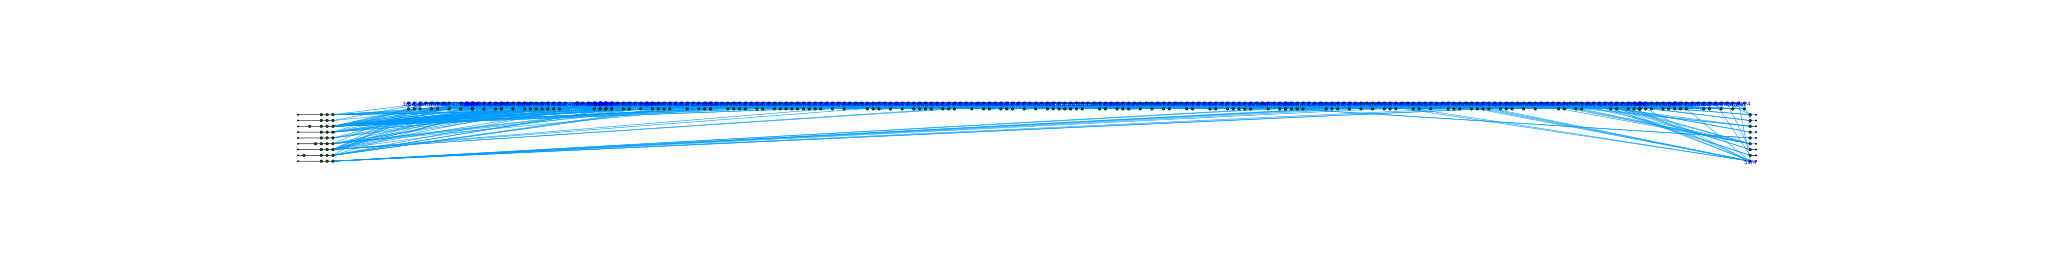

In [25]:
zx.draw(g2,figsize=(40,5))